In [52]:
import pandas as pd
import numpy as np

import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt
import mapclassify as mc
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
final = pd.read_csv('final_without_totals.csv')
for i, row in final.iterrows():
    fips = str(row['county_fips'])
    if len(fips)== 4:
        final.loc[i, 'county_fips'] = '0' + fips
        

In [ ]:
final_c = final.dropna()
final_c['aquifer_type_id'] = final_c['aquifer_type_id'].map({'confined': 1, 'unconfined': 0})
final_c.rename(columns = {'aquifer_type_id': 'confined'}, inplace = True)

In [9]:
X = final_c.drop(['slope', 'decadal_change'], axis=1) 
y = final_c[['slope', 'county_fips']] 

#### Hyperparameter Tuning the Random Forest Model

In [22]:
for n in [100, 150, 200, 250]:
    for d in [None, 10, 20]:
        print('hyperparams: n_estimators = ' + str(n) + ', max max_depth = ' + str(d))

        scale_columns  = list(final_c.drop(['slope', 'decadal_change', 'county_fips', 'confined'], axis = 1).columns)
        scaler_transform = ColumnTransformer(transformers=[('num', StandardScaler(), scale_columns)], remainder='passthrough')

        pipeline = Pipeline([('scaler', scaler_transform), 
                             ('model', RandomForestRegressor(n_estimators=n, max_depth = d, random_state=42))
                            ])
        X = final_c.drop(['slope', 'decadal_change', 'county_fips'], axis=1)
        y = final_c['slope']
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
        print("Cross-validation MSE scores:", scores)
        print("Mean cross-validation MSE score:", scores.mean())
        print('---------')

hyperparams: n_estimators = 100, max max_depth = None
Cross-validation MSE scores: [-0.60899601 -0.63182365 -0.71324935 -0.65281879 -0.76778722]
Mean cross-validation MSE score: -0.6749350040146973
---------
hyperparams: n_estimators = 100, max max_depth = 10
Cross-validation MSE scores: [-0.7242949  -0.70897026 -0.82928123 -0.73128334 -0.86854726]
Mean cross-validation MSE score: -0.7724753975664619
---------
hyperparams: n_estimators = 100, max max_depth = 20
Cross-validation MSE scores: [-0.61775531 -0.63744327 -0.72007688 -0.65684705 -0.77556432]
Mean cross-validation MSE score: -0.6815373656639723
---------
hyperparams: n_estimators = 150, max max_depth = None
Cross-validation MSE scores: [-0.60512829 -0.63229757 -0.71194419 -0.64857324 -0.76301205]
Mean cross-validation MSE score: -0.6721910704598404
---------
hyperparams: n_estimators = 150, max max_depth = 10
Cross-validation MSE scores: [-0.72384743 -0.71290629 -0.82977706 -0.73254961 -0.87079023]
Mean cross-validation MSE sco

#### Now run the best performing model and visualize prediction errors

In [55]:
X = final_c.drop(['slope', 'decadal_change'], axis=1)
y = final_c[['slope', 'county_fips']]

X_train, X_test, y_train, y_test = train_test_split(X, y['slope'], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(['confined'], axis = 1))
X_train_scaled = np.concatenate((X_train_scaled, np.array([list(X_train['confined'])]).T), axis = 1)
X_test_scaled = scaler.transform(X_test.drop(['confined'], axis = 1)) 
X_test_scaled = np.concatenate((X_test_scaled, np.array([list(X_test['confined'])]).T), axis = 1)

In [56]:
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print('MSE: ' + str(mean_squared_error(y_test, y_pred)))

MSE: 0.6127366710275666


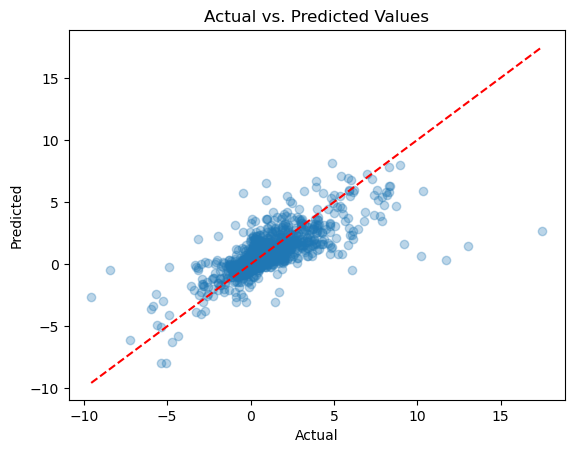

In [57]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

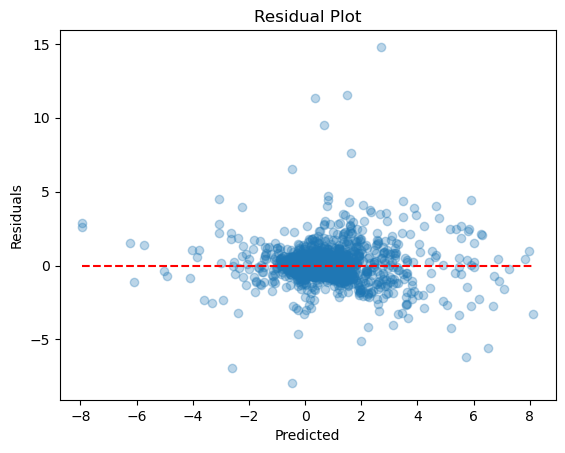

In [58]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.3)
plt.hlines(0, xmin=min(y_pred), xmax=max(y_pred), colors='red', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

#### Cross validate and visualize average prediction errors for wells/counties across all CV folds

In [29]:
kfold = KFold(n_splits=5, shuffle=True, random_state = 42)

final_MSE_list = []
final_MAE_list = []
all_counties_MAE = {}
count =0
for fold, (train_ids, test_ids) in enumerate(kfold.split(final_c)):
    count +=1
    print('split: ' + str(count))
    X_train, X_test, y_train, y_test = final_c.iloc[train_ids].drop(['slope', 'decadal_change', 'county_fips'], axis= 1), final_c.iloc[test_ids].drop(['slope', 'decadal_change', 'county_fips'], axis = 1), final_c[['slope', 'county_fips']].iloc[train_ids], final_c[['slope', 'county_fips']].iloc[test_ids]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.drop(['confined'], axis = 1))
    X_train_scaled = np.concatenate((X_train_scaled, np.array([list(X_train['confined'])]).T), axis = 1)
    X_test_scaled = scaler.transform(X_test.drop(['confined'], axis = 1)) 
    X_test_scaled = np.concatenate((X_test_scaled, np.array([list(X_test['confined'])]).T), axis = 1)

    rf = RandomForestRegressor(n_estimators=150, random_state=42)
    rf.fit(X_train_scaled, y_train['slope'])
    
    y_pred = rf.predict(X_test_scaled)
    y_test['predicted_slope'] = y_pred
    y_test['absolute_error'] = abs(y_test['predicted_slope'] - y_test['slope'])
    
    mse = mean_squared_error(y_test['slope'], y_pred)
    final_MSE_list.append(mse)
    mae = np.mean(y_test['absolute_error'])
    final_MAE_list.append(mae)
    
    display('MSE: ' + str(mse))
    display('MAE: ' + str(mae))
    
    for county in y_test['county_fips'].unique():            
        county_df = y_test[y_test['county_fips'] == county]
        county_df = county_df.reset_index()
        if county not in all_counties_MAE:
            all_counties_MAE[county] = []
        county_MAE = np.mean(county_df['absolute_error'])
        all_counties_MAE[county].append(county_MAE)
    display('----------')
    
    
    
final_MSE = np.mean(final_MSE_list)
final_MAE = np.mean(final_MAE_list)


display('final MSE: ' + str(final_MSE))
display('final MAE: ' + str(final_MAE))


split: 1


'MSE: 0.6051282944432668'

'MAE: 0.34890687162215966'

'----------'

split: 2


'MSE: 0.6322975689948575'

'MAE: 0.3669948309671189'

'----------'

split: 3


'MSE: 0.7119441939258128'

'MAE: 0.3736062649271259'

'----------'

split: 4


'MSE: 0.6485732444291391'

'MAE: 0.36030039644320916'

'----------'

split: 5


'MSE: 0.7630120505061262'

'MAE: 0.3823916560447393'

'----------'

'final MSE: 0.6721910704598404'

'final MAE: 0.3664400040008706'

In [31]:
#The below choropleth map visualisation can be attributed to https://python-graph-gallery.com/choropleth-map-geopandas-python/
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
statesToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(statesToRemove)]
geoData['county_fips'] = geoData['STATE'] + geoData['COUNTY']

In [32]:
count = 0
to_dict_MAE = {}
for key, value in all_counties_MAE.items():
    
    to_dict_MAE[str(key)] = {}
    to_dict_MAE[str(key)]['county_fips'] = str(key)
    to_dict_MAE[str(key)]['MAE'] = np.mean(value)
    
results_viz_df = pd.DataFrame(to_dict_MAE).T.reset_index(drop = True)
results_viz_df = geoData.merge(results_viz_df, how = 'left', on = 'county_fips')

<GeoAxes: title={'center': 'Mean Absolute Error per County - Random Forest Regressor\n(Crossvalidation Results)'}>

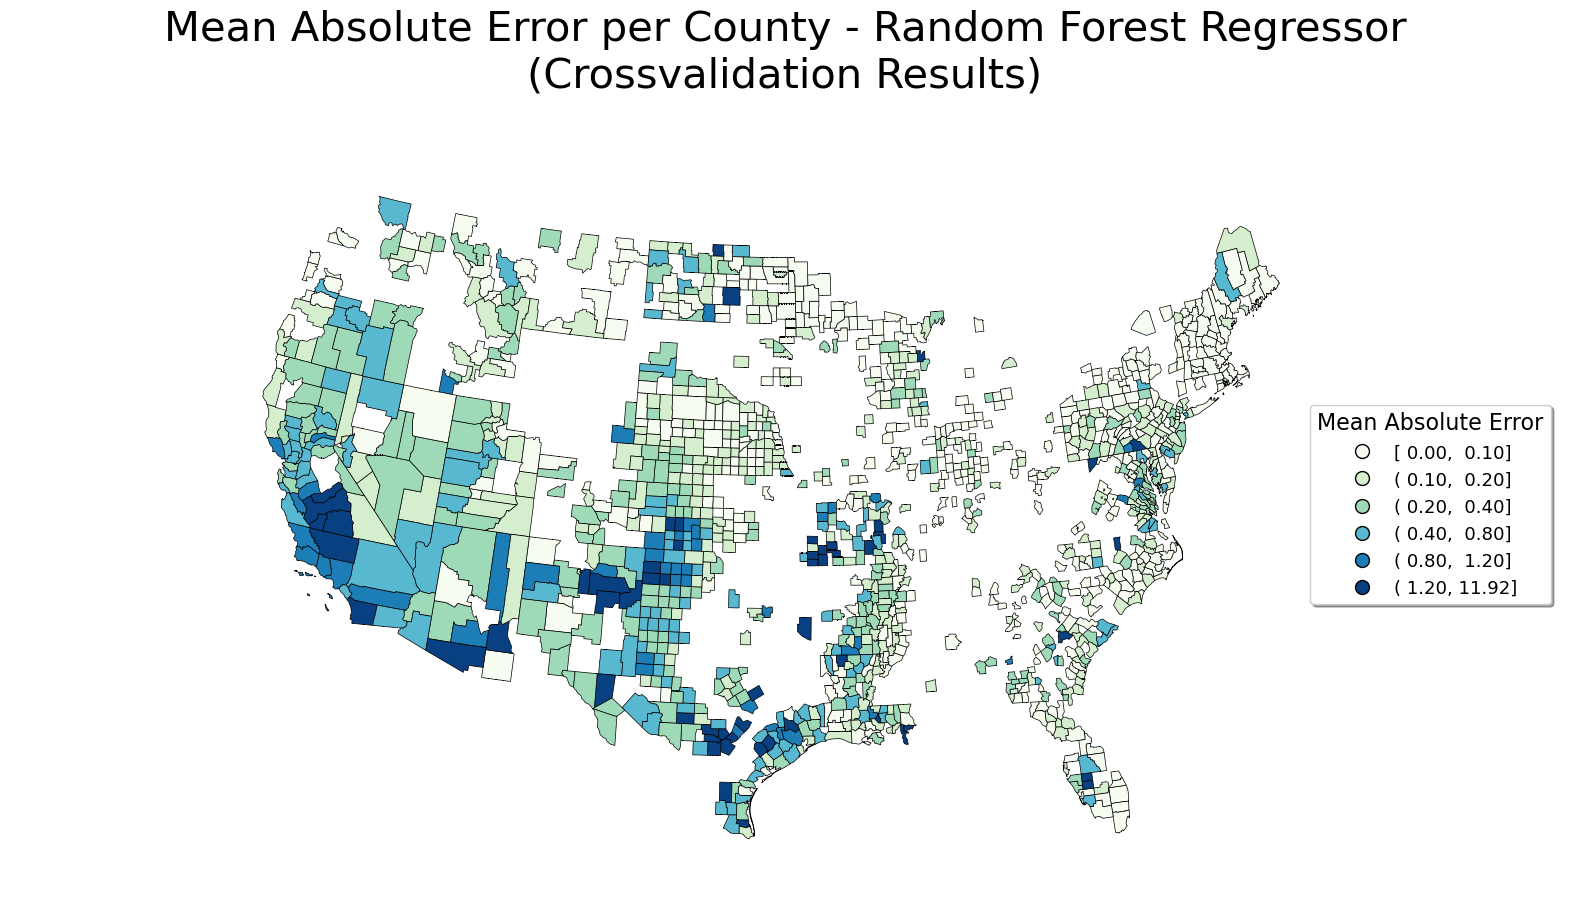

In [48]:
results_viz_df = results_viz_df.dropna(subset =['MAE'])
scheme = mc.UserDefined(results_viz_df['MAE'], bins=[.1, .2, .4,.8, 1.2])
mapping = dict([(i, s) for i, s in enumerate(scheme.get_legend_classes())])

plot1 = gplt.choropleth(
    results_viz_df,
    projection=gcrs.AlbersEqualArea(),
    hue="MAE",
    scheme=scheme, 
    cmap='GnBu',
    linewidth=.5,
    edgecolor='black',
    figsize=(20, 12),
    legend = True, 
    legend_kwargs={'loc': 'center right', 'title': 'Mean Absolute Error', 'shadow': True, 'title_fontsize': 16, 'fontsize':13}
)

count = 0
for txt in plot1.get_legend().texts:
    txt.set_text(mapping[count])
    count +=1

title = 'Mean Absolute Error per County - Random Forest Regressor\n(Crossvalidation Results)'
plot1.axes.set_title(title, fontsize=30)
plot1